Importing the required libraries

In [1]:
import os
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models


from PIL import Image
from collections import Counter

from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

c:\Users\rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Image Captions

We have 4 captioins for each image.

In [2]:
img_cap = pd.read_csv("Dataset/flickr8k/captions.txt")
img_cap.sample(10)

,image,caption
23307,3242007318_01e82171aa.jpg,Two women standing in front of a large brick b...
15217,2831656774_36982aafdb.jpg,Lady in blue top and dark pants astride a whit...
30568,3532028205_9ddd7599f8.jpg,Hockey player in red hockey shirt with white a...
4825,2089122314_40d5739aef.jpg,A dog running with a newspaper in its mouth .
8175,2364096157_eb7970a69a.jpg,A black and brown dog carries a red toy in his...
7907,2342478660_faef1afea8.jpg,A child is posing with toy pieces placed over ...
29478,3486340101_ff01d8f3f9.jpg,Blue race car raises dust cloud on road as spe...
38946,611910909_4f8e43e070.jpg,A little blond girl with a pink coat hides in ...
39675,802594049_289e3c8420.jpg,A black man with facial hair wears a navy hat ...
32767,3618504267_d7eaa495d0.jpg,A man is encouraging a small white dog to stan...


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

Loading the tokenizer and initializing the Counter

In [4]:
tokenizer = get_tokenizer("basic_english")

counter = Counter()

Building the vocabulary for captions

In [5]:
for line in img_cap["caption"].tolist():
    counter.update(tokenizer(line))

vocab = vocab(counter, min_freq = 5)

Adding the special tokens and setting the default index as UNK (unknown token)

In [6]:
unk_token = "<unk>"
pad_token = "<pad>"
sos_token = "<sos>"
eos_token = "<eos>"

vocab.insert_token(unk_token, 0)
vocab.insert_token(pad_token, 1)
vocab.insert_token(sos_token, 2)
vocab.insert_token(eos_token, 3)

vocab.set_default_index(vocab["<unk>"])

Now, defining the dataset and the creating a get_item method that returns image with their captions tokens in integer form.

In [7]:
class FlickrDataset(Dataset):

    # Initializing the paramters for the dataset
    def __init__(self, root_dir, captions_file, vocab, transform = None):

        """
        root_dir: Path to the images folder
        captions_file: Path to the CSV file containing image names and captions
        vocab: Vocabulary object
        transform: Optional transform to be applied on the images
        """

        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocab

        # Reading the captions file and storing the image names and captions in the DataFrame df
        df = pd.read_csv(captions_file)

        self.length = len(df)

        # Extracting the image names and captions from the DataFrame df
        self.captions = df["caption"]
        self.img_names = df["image"]

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):

        # Getting caption and the image for the specified index
        caption = self.captions[idx]
        img_name = self.img_names[idx]

        # Loading the image and applying the transform if provided
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        # Tokenizing the caption and converting it to a list of indices in the vocabulary
        caption_text_to_index = lambda x: [self.vocab[token] for token in tokenizer(x)]

        # Adding the start and end tokens to the caption vector and converting it to a PyTorch tensor
        caption_vec = []
        caption_vec += [vocab["<sos>"]]
        caption_vec += caption_text_to_index(caption)
        caption_vec += [vocab["<eos>"]]

        return img, torch.tensor(caption_vec)

In [8]:
class generate_batch_captions:
    def __init__(self, pad_idx, batch_first = False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        """
        Each batch: (image_tensor, caption_tensor)

        image_tensor:  [batch_size, num_channels, height, width]
        caption_tensor: [batch_size, num_words_in_caption]
        """
        # We will be seperating the images from the caption
        imgs = [item[0].unsqueeze(0) for item in batch]

        # Adding an extra dimension to the image
        imgs = torch.cat(imgs, dim = 0)

        # Separating the captions
        targets = [item[1] for item in batch]
        # Padding the captions with the pad token to make them of equal length
        targets = pad_sequence(targets, batch_first = self.batch_first, padding_value = self.pad_idx)

        return imgs, targets

Helper function for Displaying the Image

In [9]:
def display_image(inp_img, title = "Image"):

    # Unnormalizing te images
    inp_img[0] = inp_img[0] * 0.229
    inp_img[1] = inp_img[1] * 0.224
    inp_img[2] = inp_img[2] * 0.225

    inp_img[0] += 0.485
    inp_img[1] += 0.456
    inp_img[2] += 0.406

    # By default the shape of an image using PyTorch is (n_c X n_h X n_w)
    # It has to be changed to (n_h X n_w X n_c)
    inp_img = inp_img.numpy().transpose((1, 2, 0))
    plt.imshow(inp_img)
    plt.title(title)
    plt.pause(0.1)
    plt.show()

Transformations for the Image.
- Resizing the Image
- Randomly Cropping the Image
- Conversion to Tensor
- Normalization

In [10]:
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

Defining the dataset

In [11]:
root_dir = "Dataset/flickr8k/images"
captions_filepath = "Dataset/flickr8k/captions.txt"

In [12]:
flickr_dataset = FlickrDataset(
    root_dir = root_dir,
    captions_file = captions_filepath,
    vocab = vocab,
    transform = transforms
)

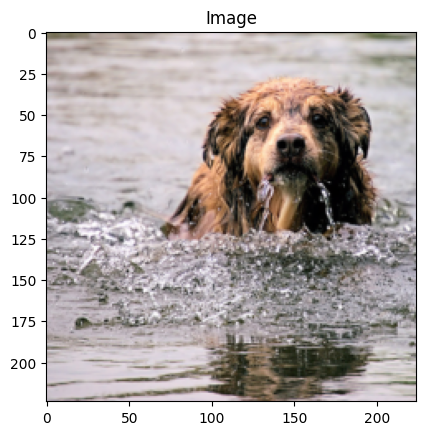

Token IDS: 
tensor([  2,   4, 226,  42,  29, 675, 221,  25, 337,  17,   3])
Caption: 
['<sos>', 'a', 'big', 'brown', 'dog', 'swims', 'towards', 'the', 'camera', '.', '<eos>']


In [13]:
# Getting the image and caption
img, ids = flickr_dataset[12345]

# Displating the image using the helper function
display_image(img)

# Printing the token IDs and the corresponding caption in the vocabulary
print("Token IDS: ")
print(ids)
print("Caption: ")
print([flickr_dataset.vocab.get_itos()[token] for token in ids.tolist()])

Defining the DataLoader

In [14]:
batch_size = 128
pad_idx = vocab["<pad>"]

data_loader = DataLoader(
    dataset = flickr_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = generate_batch_captions(pad_idx = pad_idx,
                                          batch_first = True)
)

Calling the ResNet model

In [15]:
resnet = models.resnet50()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Model is the seq2seq model. In the **encoder** pretrained resnet model is used to extract the features. **Decoder** is the implementation of the **Bahdanau Attention Decoder**.

In [16]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()

        resnet = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
        for params in resnet.parameters():
            params.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):

        # With this the shape of the images will be [batch_size, 2048, 7, 7]
        features = self.resnet(images)

        batch, feature_maps, size_1, size_2 = features.size()

        # Changing the features to [batch_size, 7, 7, 2048]
        features = features.permute(0, 2, 3, 1)

        # Reshaping the features to [batch_size, 7 * 7, 2048]
        features = features.view(batch, size_1 * size_2, feature_maps)
        return features

Now, defining the Attention Mechanism

In [17]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size, attn_size):
        super(Attention, self).__init__()

        self.attn_size = attn_size

        self.enc_U = nn.Linear(enc_hidden_size, attn_size)
        self.dec_W = nn.Linear(dec_hidden_size, attn_size)

        self.full_A = nn.Linear(attn_size, 1)

    def forward(self, features, decoder_hidden_state):

        # Making the decoder_hidden_state the same shape as of enc_U
        # [batch_size, dec_hidden_size] -> [batch_size, 1, dec_hidden_size]
        decoder_hidden_state = decoder_hidden_state.unsqueeze(1)

        # These are the features we got from EncoderCNN  [batch_size, 49, 2048]
        # [batch_size, 49, 2048] -> [batch_size, 49, attn_size]
        enc_attn = self.enc_U(features)

        # [batch_size, 1, dec_hidden_size] -> [batch_size, 1, attn_size]
        dec_attn = self.dec_W(decoder_hidden_state)

        # Combining both enc_attn and dec_attn
        # [batch_size, 49, attn_size]
        combined_state = torch.tanh(enc_attn + dec_attn)

        # attn_scores shape [batch_size, 49, 1]
        attn_scores = self.full_A(combined_state)

        # [batch_size, 49, 1] -> [batch_size, 49]
        attn_scores = attn_scores.squeeze(2) 

        # attn_weight shape [batch_size, 49]
        attn_weight = F.softmax(attn_scores, dim = 1)

        # context shape [batch_size, 49, 2048] -> [batch_size, 49] * [batch_size, 49, 2048]
        # Context has same dimensions as the encoding output i.e. the encoding_hidden_size
        context = torch.sum(attn_weight.unsqueeze(2) * features, dim = 1)

        return attn_weight, context

In [18]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_size, vocab_size, attn_size,
                       enc_hidden_size, dec_hidden_size,
                       drop_prob = 0.3):
        super(DecoderRNN, self).__init__()

        # Initialize important sizes and dimensions
        self.vocab_size = vocab_size
        self.attn_size = attn_size
        self.dec_hidden_size = dec_hidden_size

        # Embedding layer: Converts token indices to embedding vectors
        # Shape: [vocab_size, emb_size]
        self.embedding = nn.Embedding(vocab_size, emb_size)

        # Attention mechanism to align the CNN encoder features with decoder hidden states
        self.attention = Attention(enc_hidden_size, dec_hidden_size, attn_size)

        # Linear layers to initialize the hidden state (h) and cell state (c) for LSTM
        # These use the CNN encoder output features
        self.init_h = nn.Linear(enc_hidden_size, dec_hidden_size)
        self.init_c = nn.Linear(enc_hidden_size, dec_hidden_size)

        # LSTMCell to process the combined input of the embedding and attention context
        # Input to LSTM: [emb_size + enc_hidden_size], hidden state: [dec_hidden_size]
        self.lstm_cell = nn.LSTMCell(emb_size + enc_hidden_size, dec_hidden_size, bias = True)

        # Fully connected layer to generate vocabulary-sized logits (for predicting next word)
        # Output shape: [dec_hidden_size, vocab_size]
        self.fcn = nn.Linear(dec_hidden_size, vocab_size)

        # Dropout layer for regularization
        self.drop = nn.Dropout(drop_prob)

    def init_hidden_state(self, features):

        """
        Initializes the hidden state (h) and cell state (c) for the LSTM using the average of the CNN's extracted features. 

        Args:
            features: The output features from the CNN encoder. Shape: [batch_size, 49, enc_hidden_size]

        Returns:
            h, c: Initialized hidden and cell states. Shape: [batch_size, dec_hidden_size]
        """
        mean_features = torch.mean(features, dim = 1)

        h = self.init_h(mean_features)
        c = self.init_c(mean_features)

        return h, c

    def forward(self, features, captions):
        """
        Forward pass of the Decoder. Generates predicted words based on CNN features and caption embeddings.

        Args:
            features: Encoder features from the CNN. Shape: [batch_size, 49, enc_hidden_size]
            captions: Ground truth captions (shifted right). Shape: [batch_size, max_caption_length]

        Returns:
            preds: Predicted word logits for each time step. Shape: [batch_size, seq_len, vocab_size]
            attn_weights: Attention weights for each time step. Shape: [batch_size, seq_len, num_features]
        """

        # Embed the input captions to obtain word embeddings
        # Embeddings shape: [batch_size, max_caption_length, emb_size]
        embeds = self.embedding(captions)

        # Initialize the LSTM hidden state (h) and cell state (c) using the CNN features
        # h, c shape: [batch_size, dec_hidden_size]
        h, c = self.init_hidden_state(features)

        # Get the length of the sequence to decode (excluding the last token in captions)
        seq_len = len(captions[0]) - 1
        batch_size = captions.size(0)

        # Number of CNN features per image (usually 49, since resnet50 outputs 7x7 features)
        # Features shape: [batch_size, 49, 2048]
        num_features = features.size(1)

        # Placeholder for the predicted word logits at each time step
        # preds shape: [batch_size, seq_len, vocab_size]
        preds = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)

        # Placeholder for attention weights at each time step
        # attn_weights shape: [batch_size, seq_len, num_features]
        attn_weights = torch.zeros(batch_size, seq_len, num_features).to(device)

        # Loop over each time step (word) in the caption sequence
        for t in range(seq_len):

            # Compute the attention weights and context vector at the current time step
            # attn_weights shape: [batch_size, num_features]
            # context shape: [batch_size, enc_hidden_size]
            attn_weight, context = self.attention(features, h)

            # Concatenate the current word embedding and attention context vector to form LSTM input
            # lstm_input shape: [batch_size, emb_size + enc_hidden_size]
            lstm_input = torch.cat((embeds[:, t], context), dim = 1)

            # Perform one step of LSTM using the lstm_input and previous hidden state (h, c)
            # Updated hidden state and cell state: h, c shape: [batch_size, dec_hidden_size]
            h, c = self.lstm_cell(lstm_input, (h, c))

            # Pass the hidden state through the fully connected layer to generate vocabulary logits
            # output shape: [batch_size, vocab_size]
            output = self.fcn(self.drop(h))

            # Store the predictions and attention weights for the current time step
            preds[:, t] = output
            attn_weights[:, t] = attn_weight
        
        return preds, attn_weights
    
    def generate_caption(self, features, max_len = 20, vocab = None):
        """
        Generates a caption for a given image using the trained model.
        """

        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)

        attn_weights = []

        word = torch.tensor(vocab["<sos>"]).view(1, -1).to(device)
        embds = self.embedding(word)

        captions = []

        for i in range(max_len):
            attn_weight, context = self.attention(features, h)
            attn_weights.append(attn_weight.cpu().detach().numpy())

            lstm_input = torch.cat((embds[:, 0], context), dim = 1)

            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))
            output = output.view(batch_size, -1)

            predicted_word_idx = output.argmax(dim = 1)
            captions.append(predicted_word_idx.item())

            if vocab.get_itos()[predicted_word_idx.item()] == '<eos>':
                break

            embds = self.embedding(predicted_word_idx.unsqueeze(0))

        return [vocab.get_itos()[idx] for idx in captions], attn_weights

Defining the entire more containing both encoder and decoder with the Attention Layer.

In [19]:
class Img2Caption(nn.Module):
    def __init__(self,
                 emb_size,
                 vocab_size,
                 attn_size,
                 enc_hidden_size,
                 dec_hidden_size,
                 drop_prob = 0.3):
        super(Img2Caption, self).__init__()

        self.encoder = EncoderCNN()

        self.decoder = DecoderRNN(
            emb_size = emb_size,
            vocab_size = len(flickr_dataset.vocab),
            attn_size = attn_size,
            enc_hidden_size = enc_hidden_size,
            dec_hidden_size = dec_hidden_size
        )
    
    def forward(self, images, captions):
        features = self.encoder(images)
        output = self.decoder(features, captions)

        return output

Setting the HyperParameters

In [20]:
vocab_size = len(flickr_dataset.vocab)

emb_size = 300
attn_size = 256

enc_hidden_size = 2048
dec_hidden_size = 512

learning_rate = 3e-4

In [21]:
model = Img2Caption(
    emb_size = emb_size,
    vocab_size = vocab_size,
    attn_size = attn_size,
    enc_hidden_size = enc_hidden_size,
    dec_hidden_size = dec_hidden_size
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = vocab["<pad>"])
optimizer = optim.Adam(model.parameters(),
                       lr = learning_rate)

Function for saving the model

In [22]:
def save_model(model, num_epochs):
    model_state = {
        "num_epcohs": num_epochs,
        "emb_size": emb_size,
        "vocab_size": len(flickr_dataset.vocab),
        "attn_size": attn_size,
        "enc_hidden_size": enc_hidden_size,
        "dec_hidden_size": dec_hidden_size,
        "state_dict": model.state_dict()
    }
    torch.save(model_state, "attention_model_state.pth")

Training the model

Epoch [0/3], Step [100/317], Loss: 2.5191664695739746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


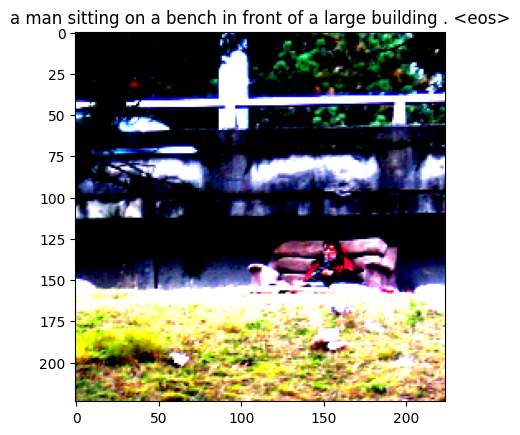

Epoch [0/3], Step [200/317], Loss: 2.5274744033813477


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


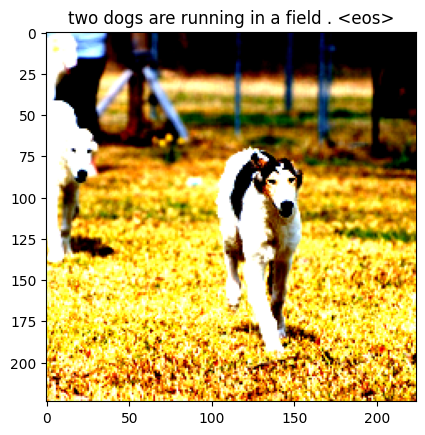

Epoch [0/3], Step [300/317], Loss: 2.4978251457214355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


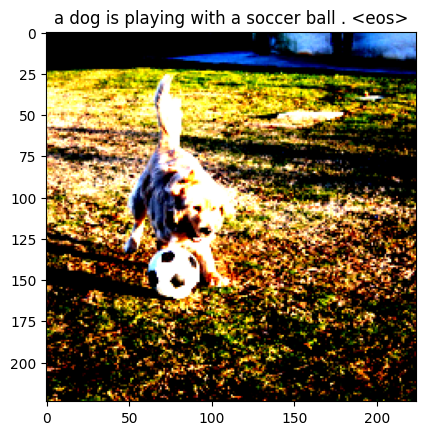

Epoch [1/3], Step [100/317], Loss: 2.5220701694488525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


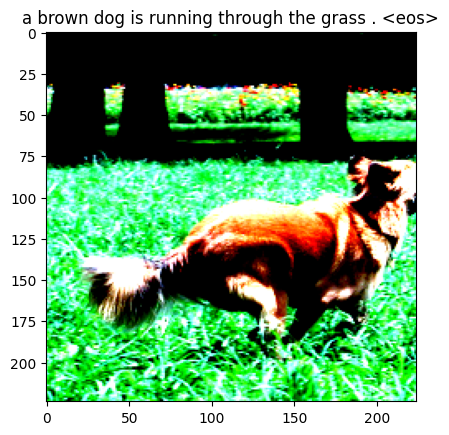

Epoch [1/3], Step [200/317], Loss: 2.4294514656066895


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


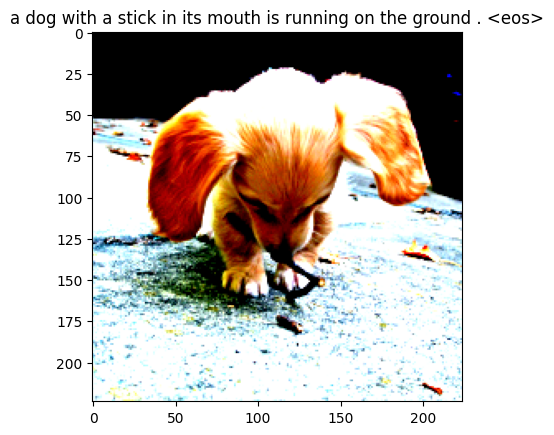

Epoch [1/3], Step [300/317], Loss: 2.539233684539795


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


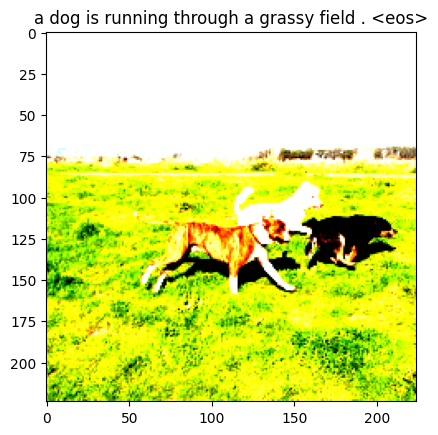

Epoch [2/3], Step [100/317], Loss: 2.4572739601135254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


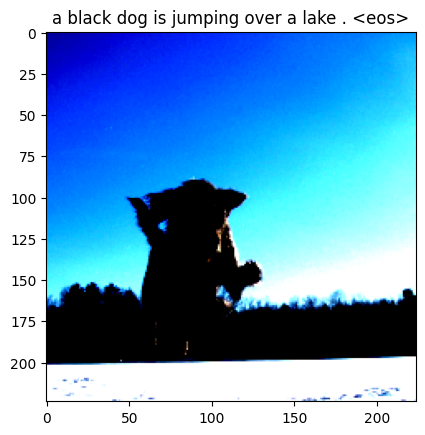

Epoch [2/3], Step [200/317], Loss: 2.4597060680389404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


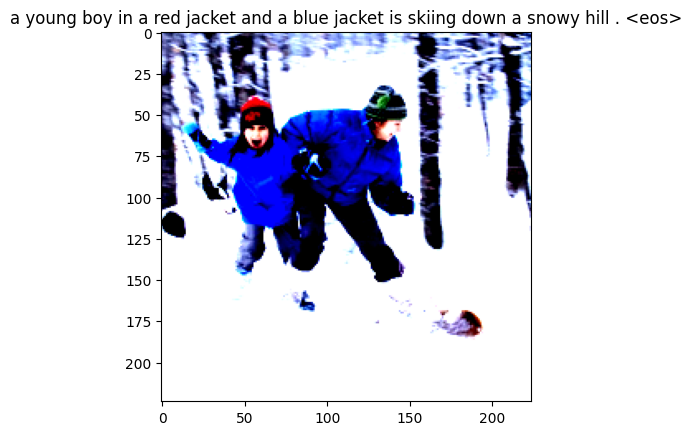

Epoch [2/3], Step [300/317], Loss: 2.2831830978393555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


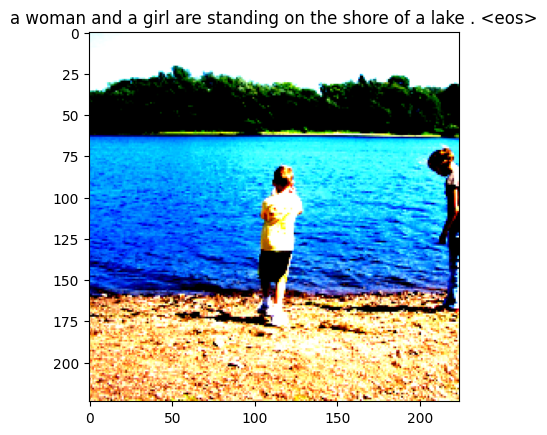

In [29]:
num_epochs = 3
print_every = 100

for epoch in range(num_epochs):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image, captions = image.to(device), captions.to(device)
        model.train()
        optimizer.zero_grad()

        outputs, attentions = model(image, captions)

        targets = captions[:, 1:]

        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        loss.backward()
        optimizer.step()

        if (idx + 1) % print_every == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{idx + 1}/{len(data_loader)}], Loss: {loss.item()}")

            model.eval()
            with torch.no_grad():
                img, _ = next(iter(data_loader))
                features = model.encoder(img[0:1].to(device))
                caps, attn_weights = model.decoder.generate_caption(features, vocab = flickr_dataset.vocab)

                caption = " ".join(caps)
                display_image(img[0], title = caption)
            
            model.train()

    save_model(model, epoch)